In [1]:
import numpy as np
import os
import scipy.stats
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.stats as st
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import phase_analysis
import phase_processor
import PGanalysis

## This notebook contains code to generate Figure 1

In [2]:
# load spontaneous phase-locking data 
os.chdir(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\final_data\fig3')
spontaneous_spiking_PCx_contra_occlusion = np.load('spontaneous_spiking_PCx_contra_occlusion.npy', allow_pickle = True)[0]
spontaneous_spiking_PCx_ipsi_occlusion = np.load('spontaneous_spiking_PCx_ipsi_occlusion.npy', allow_pickle = True)[0]

### First, we will quantify spontaneous phase-locking in the contra and ipsi occlusion conditions

In [18]:
all_percent_locked_contra = []
for expt in spontaneous_spiking_PCx_contra_occlusion['all_spontaneously_locked']:
    all_percent_locked_contra.append(np.mean(expt)*100)
    
all_percent_locked_ipsi = []
for expt in spontaneous_spiking_PCx_ipsi_occlusion['all_spontaneously_locked']:
    all_percent_locked_ipsi.append(np.mean(expt)*100)

### Plot the percentage of cells that are significantly phase-locked in each condition

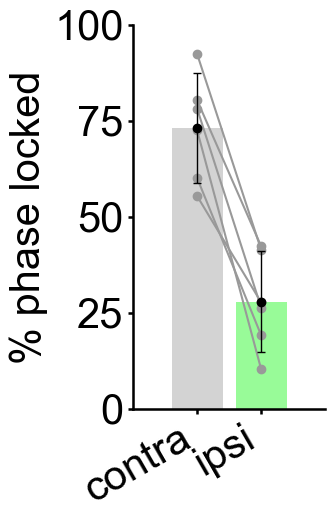

In [20]:
color = [[.4,.4,.4]]
plt.bar([0], [np.mean(all_percent_locked_contra)],color = 'lightgrey')
plt.bar([1], [np.mean(all_percent_locked_ipsi)],color = 'palegreen')

plt.ylim(0,100)
plt.xlim(-1,2)
plt.yticks([0,25,50,75,100])
plt.ylabel('% phase locked')

plt.xticks([0,1], labels = ['contra', 'ipsi'], rotation = 30, ha = 'right')

plt.plot([np.zeros(len(all_percent_locked_contra)),np.zeros(len(all_percent_locked_ipsi))+1], [np.array(all_percent_locked_contra), np.array(all_percent_locked_ipsi)],'-o', color = [.6,.6,.6])

phase_locked_err_contra = np.mean(all_percent_locked_contra)-st.t.interval(alpha=0.95, df=len(all_percent_locked_contra)-1, loc=np.mean(all_percent_locked_contra), scale=st.sem(all_percent_locked_contra))[0]
phase_locked_err_ipsi = np.mean(all_percent_locked_ipsi) -st.t.interval(alpha=0.95, df=len(all_percent_locked_ipsi)-1, loc=np.mean(all_percent_locked_ipsi), scale=st.sem(all_percent_locked_ipsi))[0]

plt.errorbar([0,1], [np.mean(np.array(all_percent_locked_contra)), np.mean(np.array(all_percent_locked_ipsi))], yerr = [phase_locked_err_contra,phase_locked_err_ipsi], fmt = 'o', capsize = 3, elinewidth = 1, capthick = 1, linewidth = .5, color= 'k')

PGanalysis.axis_fixer(ratio =2, size = 30)

In [24]:
print('Mean proportion of cells spontanouesly phase locked in contra condition = ' + str(np.mean(all_percent_locked_contra)))
print('95% confidence interval = ' + str(phase_locked_err_contra))

Mean proportion of cells spontanouesly phase locked in contra condition = 73.06994195086564
95% confidence interval = 14.338627434848767


In [25]:
print('Mean proportion of cells spontanouesly phase locked in ipsi condition = ' + str(np.mean(all_percent_locked_ipsi)))
print('95% confidence interval = ' + str(phase_locked_err_ipsi))

Mean proportion of cells spontanouesly phase locked in ipsi condition = 27.817028079672294
95% confidence interval = 13.098689197212654


In [51]:
scipy.stats.ttest_rel(all_percent_locked_contra, all_percent_locked_ipsi)

Ttest_relResult(statistic=9.094262881053618, pvalue=0.0002690225457204296)

### Next, plot the percentage of spikes exceeding the 95% confidence interval (from the shuffled data) for all cells for both conditions

In [26]:
all_percent_locked_spikes_flat_contra = np.array([spike for spikes in spontaneous_spiking_PCx_contra_occlusion['all_percent_locked_spikes'] for spike in spikes])
all_percent_locked_spikes_flat_ipsi = np.array([spike for spikes in spontaneous_spiking_PCx_ipsi_occlusion['all_percent_locked_spikes'] for spike in spikes])

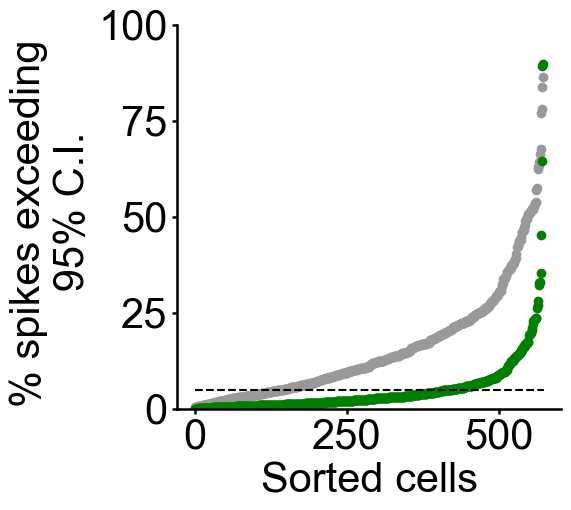

In [27]:
plt.plot(np.sort(all_percent_locked_spikes_flat_contra),'o', color = [.6,.6,.6])
plt.plot(np.sort(all_percent_locked_spikes_flat_ipsi),'go')

plt.plot([0, len(all_percent_locked_spikes_flat_contra)],[5,5],'k--')
plt.ylim(0,100)
plt.xticks([0,250,500])
plt.ylabel('% spikes exceeding \n 95% C.I.')
plt.xlabel('Sorted cells')
PGanalysis.axis_fixer(ratio = 1, size = 30)

In [50]:
scipy.stats.ttest_rel(all_percent_locked_spikes_flat_contra, all_percent_locked_spikes_flat_ipsi)

Ttest_relResult(statistic=18.41409335359775, pvalue=8.292264998681895e-60)

### Plot the phase-locked firing rates for each condition (using only cells that are significantly phase-locked in the contra condition)

In [34]:
# analyze cells that are significantly locked in the contra occlusion condition 
all_spontaneously_locked_flat_contra = np.array([curve for expt in spontaneous_spiking_PCx_contra_occlusion['all_spontaneously_locked'] for curve in expt])
significantly_locked_contra = np.where(all_spontaneously_locked_flat_contra == 1)[0]

In [35]:
# get the firing rate as a function of bin for all cells for each condition 
all_spontaneous_bin_rate_flat_contra = np.array([curve for expt in spontaneous_spiking_PCx_contra_occlusion['all_spontaneous_bin_rate'] for curve in expt])
all_spontaneous_bin_rate_flat_norm_contra = all_spontaneous_bin_rate_flat_contra/np.max(all_spontaneous_bin_rate_flat_contra,1)[:,None]

all_spontaneous_bin_rate_flat_ipsi = np.array([curve for expt in spontaneous_spiking_PCx_ipsi_occlusion['all_spontaneous_bin_rate'] for curve in expt])
all_spontaneous_bin_rate_flat_norm_ipsi = all_spontaneous_bin_rate_flat_ipsi/np.max(all_spontaneous_bin_rate_flat_ipsi,1)[:,None]

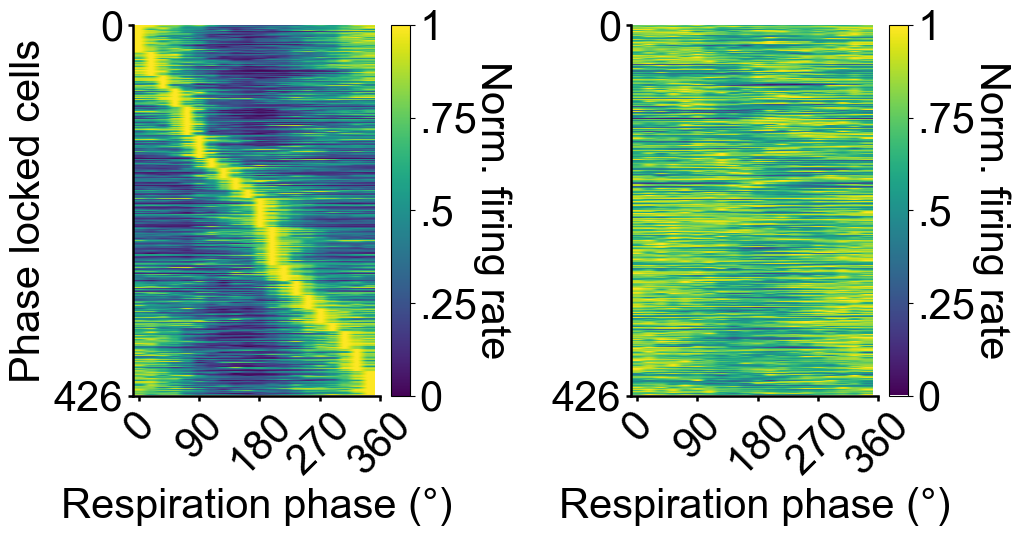

In [36]:
# plot the firing rates sorted by max bin for all cells significantly activated in the contra occlusion condition 
plt.figure(figsize = (10,10))

bins = np.arange(0,np.radians(360)+np.radians(9), np.radians(9))

plt.subplot(1,2,1)
idx = np.argsort(np.argmax(all_spontaneous_bin_rate_flat_norm_contra[significantly_locked_contra,:],1))
plt.imshow(all_spontaneous_bin_rate_flat_norm_contra[significantly_locked_contra][idx,:])
plt.xticks(np.arange(0,25,5), labels = ['0','90','180','270', '360'], rotation = 45)
plt.yticks([0, len(significantly_locked_contra)])
plt.ylabel('Phase locked cells')
plt.xlabel('Respiration phase (°)')
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
ax = plt.gca()
cbar = plt.colorbar(fraction=0.067, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Norm. firing rate', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.set_ticks([0,.25,.5,.75,1])
cbar.ax.set_yticklabels(['0','.25','.5','.75','1']);

plt.subplot(1,2,2)
plt.imshow(all_spontaneous_bin_rate_flat_norm_ipsi[significantly_locked_contra][idx,:])
plt.xticks(np.arange(0,25,5), labels = ['0','90','180','270', '360'], rotation = 45)
plt.yticks([0, len(significantly_locked_contra)])
plt.xlabel('Respiration phase (°)')
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
ax = plt.gca()
cbar = plt.colorbar(fraction=0.067, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Norm. firing rate', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.set_ticks([0,.25,.5,.75,1])
cbar.ax.set_yticklabels(['0','.25','.5','.75','1']);

### Now let's analyze the spot-stimulation data 

### First we will ask what percentage of cells any given spot activates in each condition

In [37]:
# set the target directory for contralateral control naris occlusion data
expt_list_contra = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\phase_stats\contra')
target_dir_contra = r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\phase_stats\contra'

# load the phase experiment data dictionaries 
all_phase_expts_contra = []
for expt in expt_list_contra:
    load_path = os.path.join(target_dir_contra, expt)
    phase_expt = np.load(load_path,allow_pickle = True)[0]
    all_phase_expts_contra.append(phase_expt)

In [43]:
# set the target directory for ipsilateral naris occlusion data
expt_list_ipsi = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\phase_stats\ipsi')
target_dir_ipsi = r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\phase_stats\ipsi'

# load the phase experiment data dictionaries 
all_phase_expts_ipsi = []
for expt in expt_list_ipsi:
    load_path = os.path.join(target_dir_ipsi, expt)
    phase_expt = np.load(load_path,allow_pickle = True)[0]
    all_phase_expts_ipsi.append(phase_expt)

In [44]:
def get_tuning_stats(all_phase_expts):
    all_spot_tuned_total = []
    all_spot_tuned_responsive = []
    all_spot_activated = []
    for expt in all_phase_expts: 
        stim_activated_thresh = np.sum(expt['Mann_Whitney_responsive_cell_bins']['activated'],1)
        n_stim = expt['Kruskal_pval_thresh'].shape[0]
        for stim in range(n_stim):
            if stim>0:
                activated_count = len(np.where((stim_activated_thresh[stim,:]>0))[0])
                all_count = len(stim_activated_thresh[stim,:])
                all_spot_activated.append((activated_count/all_count)*100)
                activated_tuned_count = len(np.where((expt['Kruskal_pval_thresh'][stim,:]>0)&(stim_activated_thresh[stim,:]>0))[0])
                all_count = len((stim_activated_thresh[stim,:]>0))
                all_activated = len(np.where(stim_activated_thresh[stim,:]>0)[0])
                all_spot_tuned_total.append((activated_tuned_count/all_count)*100)
                all_spot_tuned_responsive.append((activated_tuned_count/all_activated)*100)
    return all_spot_activated, all_spot_tuned_responsive

In [45]:
all_spot_activated_contra, all_spot_tuned_responsive_contra = get_tuning_stats(all_phase_expts_contra)
all_spot_activated_ipsi, all_spot_tuned_responsive_ipsi = get_tuning_stats(all_phase_expts_ipsi)

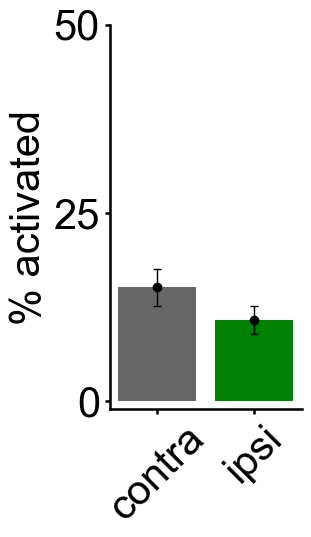

In [46]:
color = [[.4,.4,.4],'g']
plt.bar([0,1], [np.mean(all_spot_activated_contra), np.mean(all_spot_activated_ipsi)], color = color)
plt.ylim(0,50)
plt.ylim(-1,50)
plt.yticks([0,25,50])
plt.ylabel('% activated')
CI_contra = np.mean(all_spot_activated_contra) -st.t.interval(alpha=0.95, df=len(all_spot_activated_contra)-1, loc=np.mean(all_spot_activated_contra), scale=st.sem(all_spot_activated_contra))[0]
CI_ipsi = np.mean(all_spot_activated_ipsi) -st.t.interval(alpha=0.95, df=len(all_spot_activated_ipsi)-1, loc=np.mean(all_spot_activated_ipsi), scale=st.sem(all_spot_activated_ipsi))[0]
plt.xticks([0,1], labels = ['contra', 'ipsi'], rotation = 45)
plt.errorbar([0,1], [np.mean(all_spot_activated_contra), np.mean(all_spot_activated_ipsi)], yerr = [CI_contra, CI_ipsi], fmt = 'o', capsize = 3, elinewidth = 1, capthick = 1, linewidth = .5, color= 'k')
PGanalysis.axis_fixer(ratio = 2, size = 30)

In [58]:
print('Mean percentage of cells activated by each spot in the contra condition = ' + str(np.mean(all_spot_activated_contra)))
print('95% confidence interval = ' + str(CI_contra))

Mean percentage of cells activated by each spot in the contra condition = 15.11377894651507
95% confidence interval = 2.4995249891923788


In [59]:
print('Mean percentage of cells activated by each spot in the ipsi condition = ' + str(np.mean(all_spot_activated_ipsi)))
print('95% confidence interval = ' + str(CI_ipsi))

Mean percentage of cells activated by each spot in the ipsi condition = 10.77824951638745
95% confidence interval = 1.8547424816400344


In [60]:
scipy.stats.ttest_rel(all_spot_activated_contra, all_spot_activated_ipsi)

Ttest_relResult(statistic=4.834738742969322, pvalue=4.0151257962564716e-05)

### Next, we will plot some example tuning curves in each condition

In [66]:
# Load the tuning curves for all cell-stim pairs in the contra condition
expt_list_tuning = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\phase_tuning\contra')
target_dir_tuning = r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\phase_tuning\contra'

all_phase_tuning = []
for expt in expt_list_tuning:
    load_path = os.path.join(target_dir_tuning, expt)
    phase_tuning = np.load(load_path,allow_pickle = True)[0]
    all_phase_tuning.append(phase_tuning)

# concatenate tuning curves for all cells across experiments 
all_phase_tuning_concat_contra = all_phase_tuning[0]
for tun in all_phase_tuning[1:]:
    all_phase_tuning_concat_contra = np.concatenate((all_phase_tuning_concat_contra, tun), axis = 2)

In [67]:
# Load the tuning curves for all cell-stim pairs in the ipsi condition
expt_list_tuning = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\phase_tuning\ipsi')
target_dir_tuning = r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\phase_tuning\ipsi'

all_phase_tuning = []
for expt in expt_list_tuning:
    load_path = os.path.join(target_dir_tuning, expt)
    phase_tuning = np.load(load_path,allow_pickle = True)[0]
    all_phase_tuning.append(phase_tuning)

# concatenate tuning curves for all cells across experiments 
all_phase_tuning_concat_ipsi = all_phase_tuning[0]
for tun in all_phase_tuning[1:]:
    all_phase_tuning_concat_ipsi = np.concatenate((all_phase_tuning_concat_ipsi, tun), axis = 2)

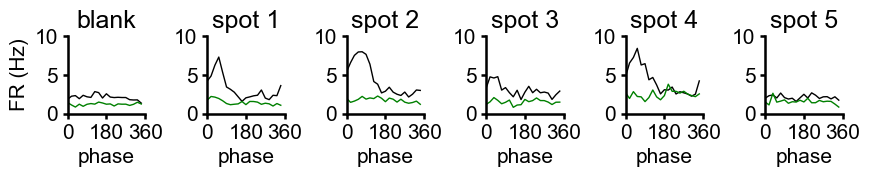

In [70]:
cell = 148
phase_analysis.plot_contra_ipsi_spot_tuning_curves(all_phase_tuning_concat_contra, all_phase_tuning_concat_ipsi, cell, ylim =10)

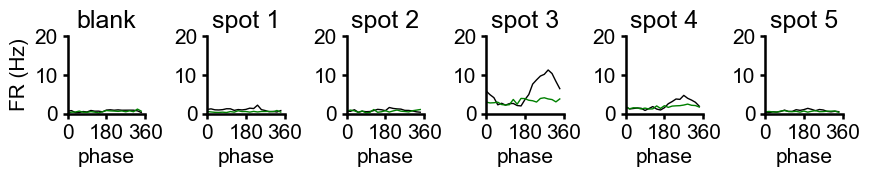

In [72]:
cell = 360
phase_analysis.plot_contra_ipsi_spot_tuning_curves(all_phase_tuning_concat_contra, all_phase_tuning_concat_ipsi, cell, ylim =20)

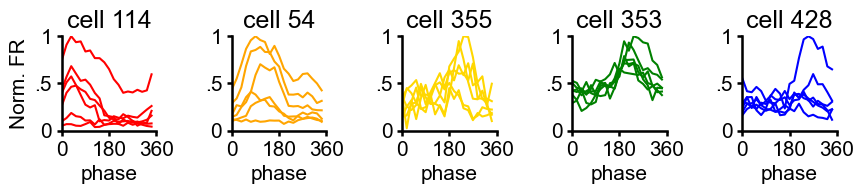

In [77]:
# plot all tuning curves for example cells with different preferences (contra)
plt.figure(figsize = (10,30))
cells = [114,54,355,353,428]
colors = ['red', 'orange','gold','green','blue']
phases = np.arange(0,360,18)
for cell_n, cell in enumerate(cells):
    plt.subplot(1,5,cell_n+1)
    for stim in range(all_phase_tuning_concat_contra.shape[0]):
        plt.plot(phases,all_phase_tuning_concat_contra[stim,:,cell]/np.max(all_phase_tuning_concat_contra[:,:,cell]),color = colors[cell_n])
    #plt.plot(phases,tuning[0,:,cell]/np.max(tuning[:,:,cell]),color = 'k')
    plt.ylim(0,1)
    plt.xlim(0,360)
    plt.xticks([0,180,360])
    plt.yticks([0,.5,1], labels = ['0','.5','1'])
    plt.title('cell ' + str(cell))
    plt.xlabel('phase')
    if (cell_n == 0) or (cell_n == 5):
        plt.ylabel('Norm. FR')
    PGanalysis.axis_fixer(ratio = 1, size = 15)

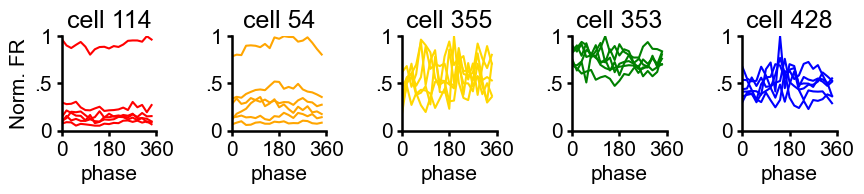

In [78]:
# plot the same cells (ipsi)
plt.figure(figsize = (10,30))
cells = [114,54,355,353,428]
colors = ['red', 'orange','gold','green','blue']
phases = np.arange(0,360,18)
for cell_n, cell in enumerate(cells):
    plt.subplot(1,5,cell_n+1)
    for stim in range(all_phase_tuning_concat_ipsi.shape[0]):
        plt.plot(phases,all_phase_tuning_concat_ipsi[stim,:,cell]/np.max(all_phase_tuning_concat_ipsi[:,:,cell]),color = colors[cell_n], alpha = 1)
    #plt.plot(phases,tuning[0,:,cell]/np.max(tuning[:,:,cell]),color = 'k')
    plt.ylim(0,1)
    plt.xlim(0,360)
    plt.xticks([0,180,360])
    plt.yticks([0,.5,1], labels = ['0','.5','1'])
    plt.title('cell ' + str(cell))
    plt.xlabel('phase')
    if (cell_n == 0) or (cell_n == 5):
        plt.ylabel('Norm. FR')
    PGanalysis.axis_fixer(ratio = 1, size = 15)

### Plot a summary of the percentage of cells tuned in each condition

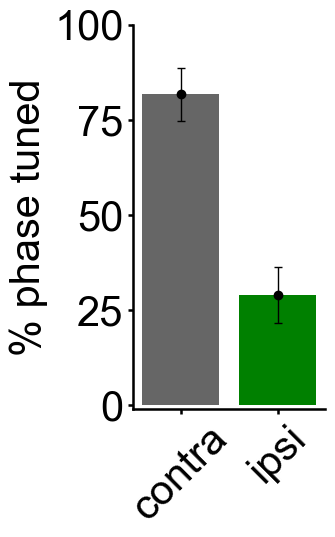

In [82]:
color = [[.4,.4,.4],'g']
plt.bar([0,1], [np.mean(all_spot_tuned_responsive_contra), np.mean(all_spot_tuned_responsive_ipsi)], color = color)
plt.ylim(-1,100)
plt.yticks([0,25,50,75,100])
plt.ylabel('% phase tuned')
CI_contra = np.mean(all_spot_tuned_responsive_contra) -st.t.interval(alpha=0.95, df=len(all_spot_tuned_responsive_contra)-1, loc=np.mean(all_spot_tuned_responsive_contra), scale=st.sem(all_spot_tuned_responsive_contra))[0]
CI_ipsi = np.mean(all_spot_tuned_responsive_ipsi) -st.t.interval(alpha=0.95, df=len(all_spot_tuned_responsive_ipsi)-1, loc=np.mean(all_spot_tuned_responsive_ipsi), scale=st.sem(all_spot_tuned_responsive_ipsi))[0]
plt.xticks([0,1], labels = ['contra', 'ipsi'], rotation = 45)
plt.errorbar([0,1], [np.mean(all_spot_tuned_responsive_contra), np.mean(all_spot_tuned_responsive_ipsi)], yerr = [CI_contra, CI_ipsi], fmt = 'o', capsize = 3, elinewidth = 1, capthick = 1, linewidth = .5, color= 'k')
PGanalysis.axis_fixer(ratio = 2, size = 30)

In [83]:
print('Mean percentage of responsive cells that are tuned in contra condition = ' + str(np.mean(all_spot_tuned_responsive_contra)))
print('95% confidence interval = ' + str(CI_contra))

Mean percentage of responsive cells that are tuned in contra condition = 81.663888158625
95% confidence interval = 7.003243358647538


In [84]:
print('Mean percentage of responsive cells that are tuned in ipsi condition = ' + str(np.mean(all_spot_tuned_responsive_ipsi)))
print('95% confidence interval = ' + str(CI_ipsi))

Mean percentage of responsive cells that are tuned in ipsi condition = 28.881481822271294
95% confidence interval = 7.411884142418234


### Plot all of the tuning curves for all cell-spot pairs significantly activated in the contra occlusion condition. Plot the same pairs in the ipsi condition. 

In [91]:
# concatenate this set of fields using the dict_key_concatenator. We will use these concatenated fields in later analyses. 
dict_keys = ['stimulation_phase_preference']
concat_dict_contra = {}
for key in dict_keys:
    concat_dict_contra[key] = phase_analysis.dict_key_concatenator(all_phase_expts_contra, key)

In [92]:
# use non-nan values to find signficantly activated cell-spot pairs 
stimulation_phase_preference_contra = concat_dict_contra['stimulation_phase_preference']

In [93]:
# get the tuning curves for all significantly activating spots for all cells 
n_cells = all_phase_tuning_concat_contra.shape[2]
all_responsive_spot_tuning_curves_contra = []
all_responsive_spot_tuning_curves_ipsi = []
for cell in range(n_cells):
    # pull out spots that significantly activate the cell (a non-nan stimulation phase preference)
    responsive_spots = np.where(~np.isnan(stimulation_phase_preference_contra[:,cell]))[0]
    if len(responsive_spots)>0:
        responsive_spot_tuning_curves_contra = all_phase_tuning_concat_contra[responsive_spots,:,cell]
        all_responsive_spot_tuning_curves_contra.append(responsive_spot_tuning_curves_contra)
        responsive_spot_tuning_curves_ipsi = all_phase_tuning_concat_ipsi[responsive_spots,:,cell]
        all_responsive_spot_tuning_curves_ipsi.append(responsive_spot_tuning_curves_ipsi)

In [94]:
# flatten the list so we have an n_cell_spot_pairs x n_bins matrix
all_responsive_spot_tuning_curves_flat_contra = np.array([spot for cell in all_responsive_spot_tuning_curves_contra for spot in cell])
# normalize the tuning curves
all_stim_tuning_ravel_norm_contra = all_responsive_spot_tuning_curves_flat_contra/np.max(all_responsive_spot_tuning_curves_flat_contra,1)[:,None]

# flatten the list so we have an n_cell_spot_pairs x n_bins matrix
all_responsive_spot_tuning_curves_flat_ipsi = np.array([spot for cell in all_responsive_spot_tuning_curves_ipsi for spot in cell])
# normalize the tuning curves
all_stim_tuning_ravel_norm_ipsi = all_responsive_spot_tuning_curves_flat_ipsi/np.max(all_responsive_spot_tuning_curves_flat_ipsi,1)[:,None]

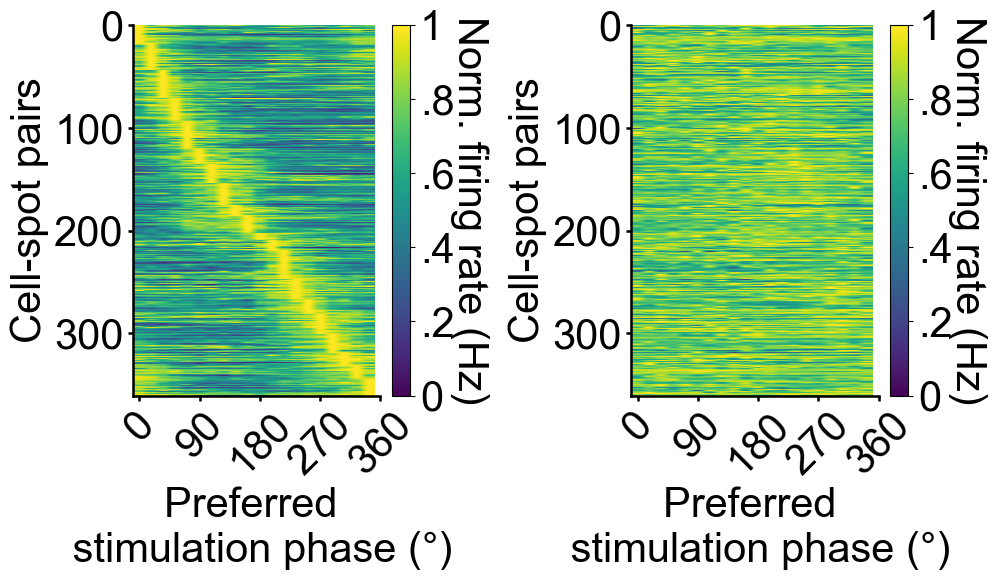

In [95]:
plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
idx = np.argsort(np.argmax(all_stim_tuning_ravel_norm_contra,1))
fig = plt.imshow(all_stim_tuning_ravel_norm_contra[idx],aspect = 'auto')
plt.xticks(np.arange(0,25,5), labels = [str(x) for x in np.arange(0,450,90)], rotation = 45)
plt.clim(0,1)
plt.xlabel('Preferred \n stimulation phase (°)')
plt.ylabel('Cell-spot pairs')
ax = plt.gca()
cbar = plt.colorbar(fraction=0.067, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_yticks([0,.2,.4,.6,.8,1])
cbar.ax.set_yticklabels(['0', '.2','.4','.6','.8','1'])
cbar.ax.set_ylabel('Norm. firing rate (Hz)', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
PGanalysis.axis_fixer(ratio = 1.5, size = 30)

plt.subplot(1,2,2)
fig = plt.imshow(all_stim_tuning_ravel_norm_ipsi[idx],aspect = 'auto')
plt.xticks(np.arange(0,25,5), labels = [str(x) for x in np.arange(0,450,90)], rotation = 45)
plt.clim(0,1)
plt.xlabel('Preferred \n stimulation phase (°)')
plt.ylabel('Cell-spot pairs')
ax = plt.gca()
cbar = plt.colorbar(fraction=0.067, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_yticks([0,.2,.4,.6,.8,1])
cbar.ax.set_yticklabels(['0', '.2','.4','.6','.8','1'])
cbar.ax.set_ylabel('Norm. firing rate (Hz)', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
PGanalysis.axis_fixer(ratio = 1.5, size = 30)

### Finally, let's perform stimulation phase decoding for both contra and ipsi-occlusion trials

In [144]:
# set the target directory for trial-by-trial spike counts over the 300ms response period for each experiment in the contra condition
expt_list = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\population_analysis_data\contra')
target_dir = r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\population_analysis_data\contra'

In [145]:
# Contra occlusion trials: bin the spike counts by the phase of OB stimulation. For each phase bin, we will use the first 15 trials of stimulation. 
all_phase_expts_contra = []
for expt in expt_list:
    load_path = os.path.join(target_dir, expt)
    phase_expt = np.load(load_path,allow_pickle = True)[0]
    binned_spike_counts = phase_analysis.bin_spike_counts_by_phase(phase_expt['trial_type_spike_counts'], phase_expt['bin_indices_all'], max_trial = 15)
    all_phase_expts_contra.append(np.array(binned_spike_counts))

In [146]:
# set the target directory for trial-by-trial spike counts over the 300ms response period for each experiment in the ipsi occlusion condition
expt_list = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\population_analysis_data\ipsi')
target_dir = r'Z:\robin\Paper\phase_coding_manuscript\data\fig2\population_analysis_data\ipsi'

In [147]:
# Ipsi occlusion trials: bin the spike counts by the phase of OB stimulation. For each phase bin, we will use the first 15 trials of stimulation. 
all_phase_expts_ipsi = []
for expt in expt_list:
    load_path = os.path.join(target_dir, expt)
    phase_expt = np.load(load_path,allow_pickle = True)[0]
    binned_spike_counts = phase_analysis.bin_spike_counts_by_phase(phase_expt['trial_type_spike_counts'], phase_expt['bin_indices_all'], max_trial = 15)
    all_phase_expts_ipsi.append(np.array(binned_spike_counts))

In [148]:
# set some useful parameters
n_spots = all_phase_expts[0].shape[0] # 11 spots (10 and 1 blank)
n_bins = all_phase_expts[0].shape[1] # 20 bins
n_trials = 15 # hard-coded, we will analyze the first 15 trials of each stimulation-phase for each spot

In [149]:
# concatenate cells across experiments for all spots (excluding the blank)
all_phase_expts_spot_cat_contra = all_phase_expts_contra[0][1:,:,:,:]
for expt in all_phase_expts_contra[1:]:
    all_phase_expts_spot_cat_contra = np.concatenate((all_phase_expts_spot_cat_contra, expt[1:,:,:,:]), axis = 2)
    
all_phase_expts_spot_cat_ipsi = all_phase_expts_ipsi[0][1:,:,:,:]
for expt in all_phase_expts_ipsi[1:]:
    all_phase_expts_spot_cat_ipsi = np.concatenate((all_phase_expts_spot_cat_ipsi, expt[1:,:,:,:]), axis = 2)

In [150]:
train_data_contra, labels = phase_analysis.generate_training_data_phase_decoder(all_phase_expts_spot_cat_contra)
train_data_ipsi, labels = phase_analysis.generate_training_data_phase_decoder(all_phase_expts_spot_cat_ipsi)

In [151]:
# Now, let's train an svm classifier using the contra data 
X_train = train_data_contra
y_train = labels 
svm_clf = SVC(kernel = 'linear')

# train and test the classifier using 5-fold cross-validation
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
conf_mx = confusion_matrix(y_train, y_train_pred)

# to get the % accuracy, divide the matrix by the number of trials 
row_sums = conf_mx.sum(axis = 1, keepdims = True)
conf_mx_contra = conf_mx/row_sums

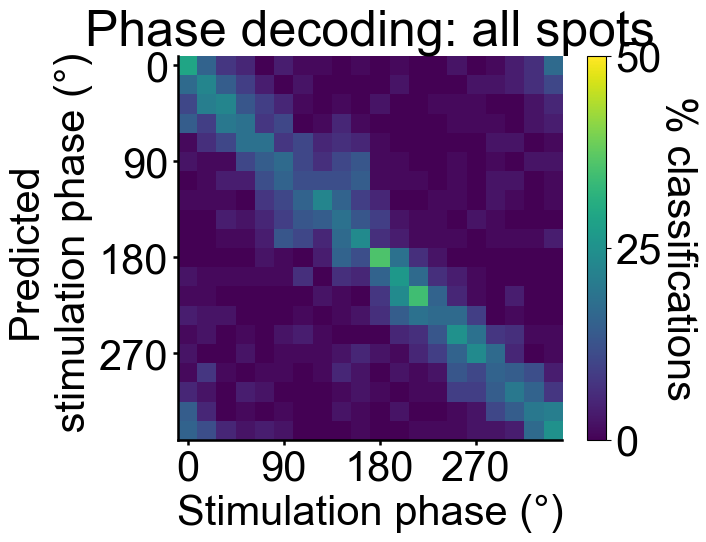

In [152]:
# plot the phase classification accuracy for spot stimulation in the contra occlusion condition
plt.imshow(conf_mx_contra)
plt.title('Phase decoding: all spots')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 30)

In [153]:
# Now, let's train an svm classifier using the ipsi data  
X_train = train_data_ipsi
y_train = labels 
svm_clf = SVC(kernel = 'linear')

# train and test the classifier using 5-fold cross-validation
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
conf_mx = confusion_matrix(y_train, y_train_pred)

# to get the % accuracy, divide the matrix by the number of trials 
row_sums = conf_mx.sum(axis = 1, keepdims = True)
conf_mx_ipsi = conf_mx/row_sums

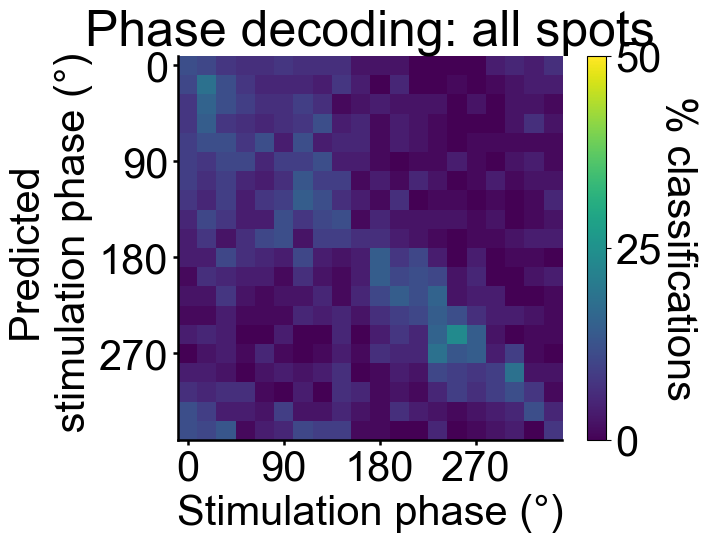

In [154]:
# plot the phase classification accuracy for spot stimulation in the ipsi occlusion condition
plt.imshow(conf_mx_ipsi)
plt.title('Phase decoding: all spots')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 30)

In [155]:
# Here, we will shift each row of the matrix so that the correct bin is centered.
# Do this for contra and ipsi analyses
n_rolls = int(conf_mx_contra.shape[0]/2)
t = np.arange((n_rolls),(n_rolls)*-1,-1)
rolled_mat_spots_contra = np.zeros_like(conf_mx_contra)
rolled_mat_spots_ipsi = np.zeros_like(conf_mx_ipsi)
for roll_n, roll in enumerate(t):
    rolled_mat_spots_contra[roll_n,:] = np.roll(conf_mx_contra[roll_n,:],roll)
    rolled_mat_spots_ipsi[roll_n,:] = np.roll(conf_mx_ipsi[roll_n,:],roll)

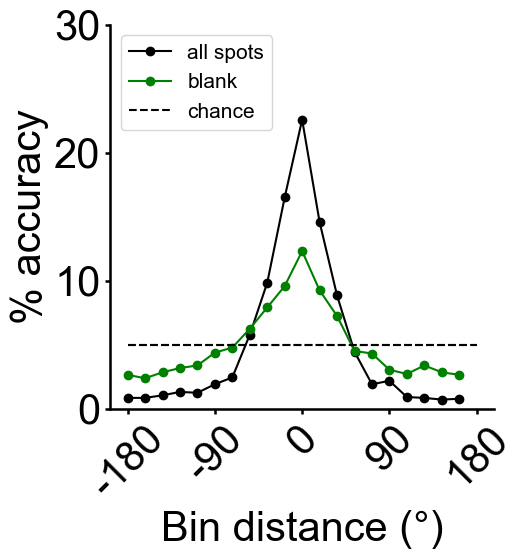

In [157]:
# plot classifier accuracy as a function of bin distance 
plt.plot(np.mean(rolled_mat_spots_contra,0),'-ko', label = 'all spots')
plt.plot(np.mean(rolled_mat_spots_ipsi,0),'-go', label = 'blank')
plt.ylim(0,.3)
plt.ylabel('% accuracy')
plt.yticks([0,.1,.2,.3], labels = ['0','10','20','30'])
plt.xticks(np.arange(0,25,5), labels = [-180,-90,0,90,180])
plt.xlabel('Bin distance (°)')
PGanalysis.axis_fixer(ratio = 1, size = 30)

plt.ylim(0,.3)
plt.plot([0,20],[1/20, 1/20], 'k--')
plt.ylabel('% accuracy')
plt.yticks([0,.1,.2,.3], labels = ['0','10','20','30'])
plt.xticks(np.arange(0,25,5), labels = [-180,-90,0,90,180], rotation = 45)
plt.xlabel('Bin distance (°)')
plt.plot([0,20],[1/20, 1/20], 'k--', label = 'chance')
plt.legend(loc = 'upper left', fontsize = 15)
PGanalysis.axis_fixer(ratio = 1, size = 30)